# Financial Time Series Analysis
# Exploratory analysis and volatility

In this notebook I will compute the daily log-returns and model their behaviour with the hystorical data.

Before running this notebook, it is necesarry to use the Data_collection.ipynb notebook.

In [1]:
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import laplace, norm
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
import math

In [2]:
data = pd.read_csv('../data/financial_data.csv', index_col=0, parse_dates=True)
data.head()

,Close_ACS.MC,Close_ACX.MC,Close_AENA.MC,Close_AMS.MC,Close_ANA.MC,Close_BBVA.MC,Close_BKT.MC,Close_CABK.MC,Close_CLNX.MC,Close_COL.MC,...,Volume_MTS.MC,Volume_NTGY.MC,Volume_RED.MC,Volume_REP.MC,Volume_ROVI.MC,Volume_SAB.MC,Volume_SAN.MC,Volume_SCYR.MC,Volume_SLR.MC,Volume_TEF.MC
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-11,16.940952,7.748485,87.818970,35.313824,49.867825,5.248390,2.825591,2.654470,11.113306,4.587703,...,264489,1122420,5608440,5718597,8943,26396456,67946568,10477838,221773,25738355
2015-05-12,16.728851,7.705486,88.067459,35.695255,49.743042,5.219527,2.861327,2.655066,11.187394,4.580408,...,800373,2414239,5672096,7923122,14322,36956820,74136179,8688260,211602,127886879
2015-05-13,16.633675,7.929081,88.624107,35.461189,49.632118,5.214909,2.900387,2.644336,11.483747,4.624171,...,572064,1527136,2489748,9626474,9754,32088105,58436689,8717111,73722,90652907
2015-05-14,16.995333,8.055215,93.196457,35.331165,50.068893,5.287067,2.926564,2.668777,11.706014,4.602290,...,2017243,1273382,2958900,5289364,8238,35337405,33497163,6514814,62359,69659502
2015-05-15,16.573853,8.055215,93.733208,35.491539,49.749981,5.236268,2.894154,2.635991,11.409656,4.631464,...,1137415,1477460,2967068,10968719,4615,21808416,72000982,4285704,1070468,70445819


## 2.1. Initial Visualization

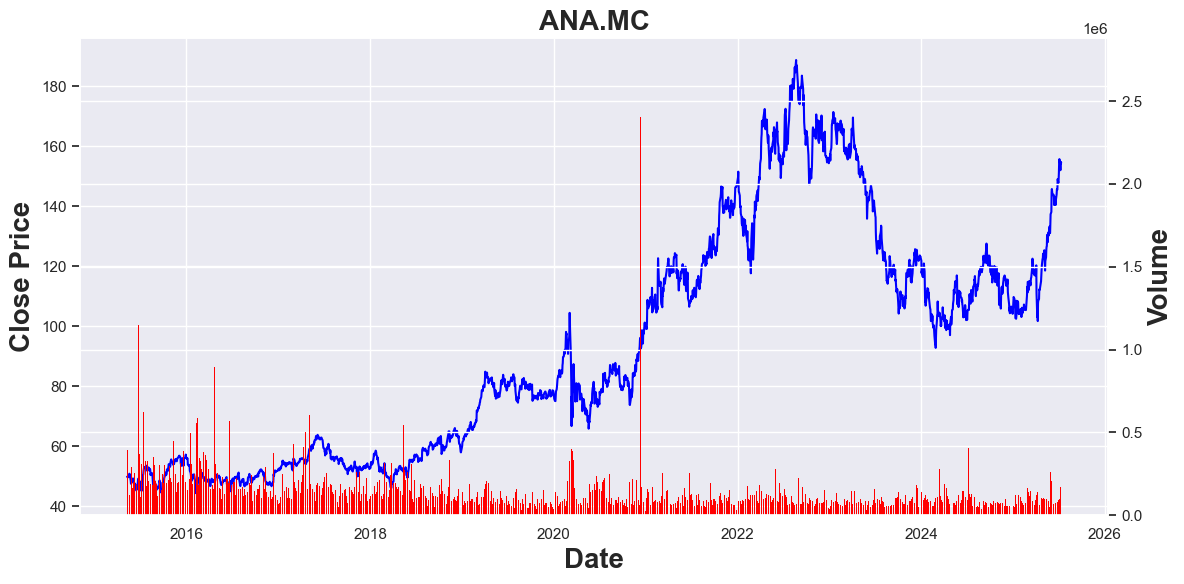

In [3]:
def Visual(data,  asset_name):
    sns.set(style="darkgrid")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Price
    sns.lineplot(data=data, x=data.index,y=f"Close_{asset_name}", ax=ax1, color='blue')
    ax1.set_xlabel("Date", fontsize=20, fontweight='bold')
    ax1.set_ylabel("Close Price", fontsize=20, fontweight='bold')
    ax1.tick_params(axis='y')

    # Volume
    volume_col = f"Volume_{asset_name}"
    if volume_col in data.columns:
        ax2 = ax1.twinx()
        ax2.bar( data.index, data[volume_col], color='red', edgecolor='black', linewidth=0, width=1   )

        ax2.set_ylabel("Volume", fontsize=20, fontweight='bold')
        ax2.tick_params(axis='y')


    plt.title(asset_name, fontsize=20, fontweight='bold')
    plt.tight_layout()

    plt.show()

Visual(data,  "ANA.MC")

## 2.2. Returns

In [4]:
close_cols = [col for col in data.columns if col.startswith("Close_")]
returns = np.log(data[close_cols] / data[close_cols].shift(1))
returns = returns.dropna()
returns.to_csv('../data/log_returns.csv')
returns.describe()

,Close_ACS.MC,Close_ACX.MC,Close_AENA.MC,Close_AMS.MC,Close_ANA.MC,Close_BBVA.MC,Close_BKT.MC,Close_CABK.MC,Close_CLNX.MC,Close_COL.MC,...,Close_MTS.MC,Close_NTGY.MC,Close_RED.MC,Close_REP.MC,Close_ROVI.MC,Close_SAB.MC,Close_SAN.MC,Close_SCYR.MC,Close_SLR.MC,Close_TEF.MC
count,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,...,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000
mean,0.000462,0.000128,-0.000508,0.000272,0.000435,0.000346,0.000533,0.000398,0.000409,0.000094,...,0.000196,0.000314,0.000189,0.000128,0.000552,0.000259,0.000187,0.000127,0.000901,-0.000152
std,0.019194,0.019737,0.048282,0.018555,0.017947,0.021385,0.019352,0.021396,0.017588,0.017654,...,0.028261,0.015084,0.012033,0.019855,0.019702,0.026707,0.021598,0.022194,0.032531,0.016413
min,-0.209149,-0.154334,-2.306767,-0.175553,-0.192247,-0.176490,-0.171350,-0.200009,-0.108365,-0.169864,...,-0.200695,-0.182553,-0.143584,-0.163991,-0.177807,-0.214337,-0.221724,-0.230377,-0.327714,-0.175791
25%,-0.008135,-0.010630,-0.006888,-0.007851,-0.008405,-0.009732,-0.009001,-0.011090,-0.009150,-0.008436,...,-0.014354,-0.006310,-0.006118,-0.009463,-0.009187,-0.011803,-0.011002,-0.009808,-0.016022,-0.008195
50%,0.001030,0.000000,0.000762,0.000653,0.000904,0.000777,0.000662,0.000533,0.000000,0.000609,...,0.000000,0.000762,0.000282,0.000292,0.000000,0.000537,0.000452,0.000652,0.000000,0.000000
75%,0.009055,0.010732,0.008801,0.009199,0.010011,0.011167,0.010309,0.011803,0.010190,0.009348,...,0.014790,0.007642,0.006738,0.010136,0.011268,0.013603,0.011475,0.011322,0.016860,0.008145
max,0.229891,0.125964,0.179468,0.139789,0.138894,0.154036,0.181504,0.139573,0.115369,0.179011,...,0.167919,0.143951,0.068866,0.167427,0.096460,0.219867,0.175818,0.125206,0.189180,0.163842


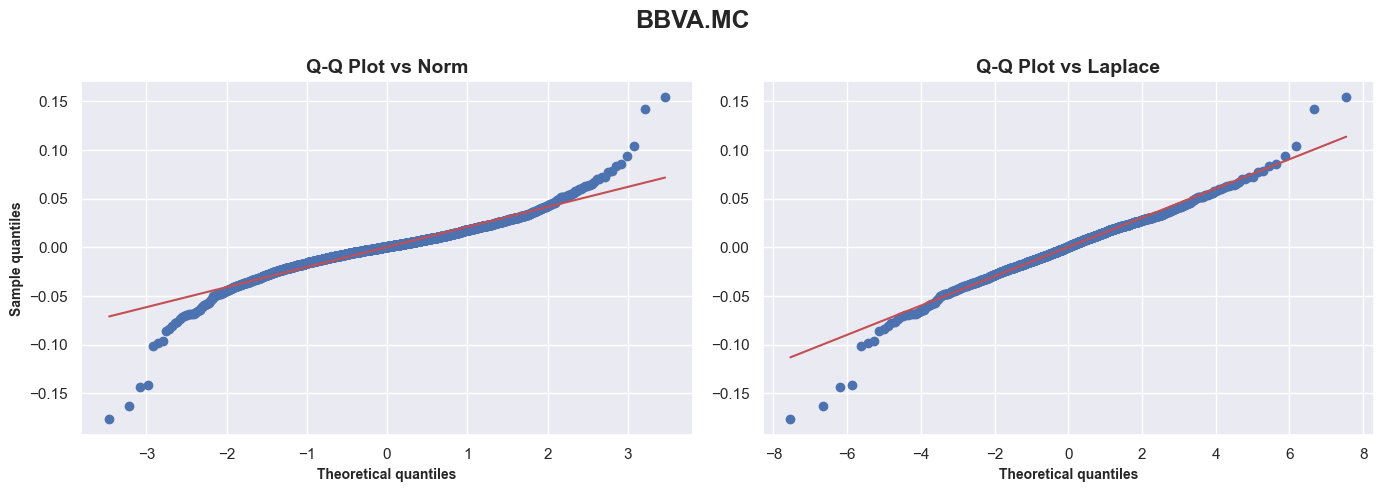

In [5]:
def return_dist_and_qq(data, asset, dist1='norm', dist2='laplace'):
    column_name = f"Close_{asset}"
    
    if column_name not in data.columns:
        raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    #sns.histplot(returns[column_name], kde=True, ax=axes[0])
    #axes[0].set_yscale("log")
    #axes[0].set_xlabel("Return", fontsize=12, fontweight='bold')
    #axes[0].set_ylabel("Freq", fontsize=12, fontweight='bold')
    #axes[0].set_title(f"Return Distribution - {asset}", fontsize=14, fontweight='bold')
    #axes[0].set_ylim(0.1, 1000)
    
    
    fig.suptitle(f"{asset}", fontsize=18, fontweight='bold')
    stats.probplot(returns[column_name].dropna(), dist=dist1, plot=axes[0])
    axes[0].set_title(f"Q-Q Plot vs {dist1.capitalize()}", fontsize=14, fontweight='bold')
    axes[0].grid(True)

    stats.probplot(returns[column_name].dropna(), dist=dist2, plot=axes[1])
    axes[1].set_title(f"Q-Q Plot vs {dist2.capitalize()}", fontsize=14, fontweight='bold')
    axes[1].grid(True)

    axes[0].set_xlabel("Theoretical quantiles", fontsize=10, fontweight='bold')
    axes[1].set_xlabel("Theoretical quantiles", fontsize=10, fontweight='bold')
    
    axes[0].set_ylabel("Sample quantiles", fontsize=10, fontweight='bold')
    axes[1].set_ylabel("", fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

return_dist_and_qq(returns, "BBVA.MC")

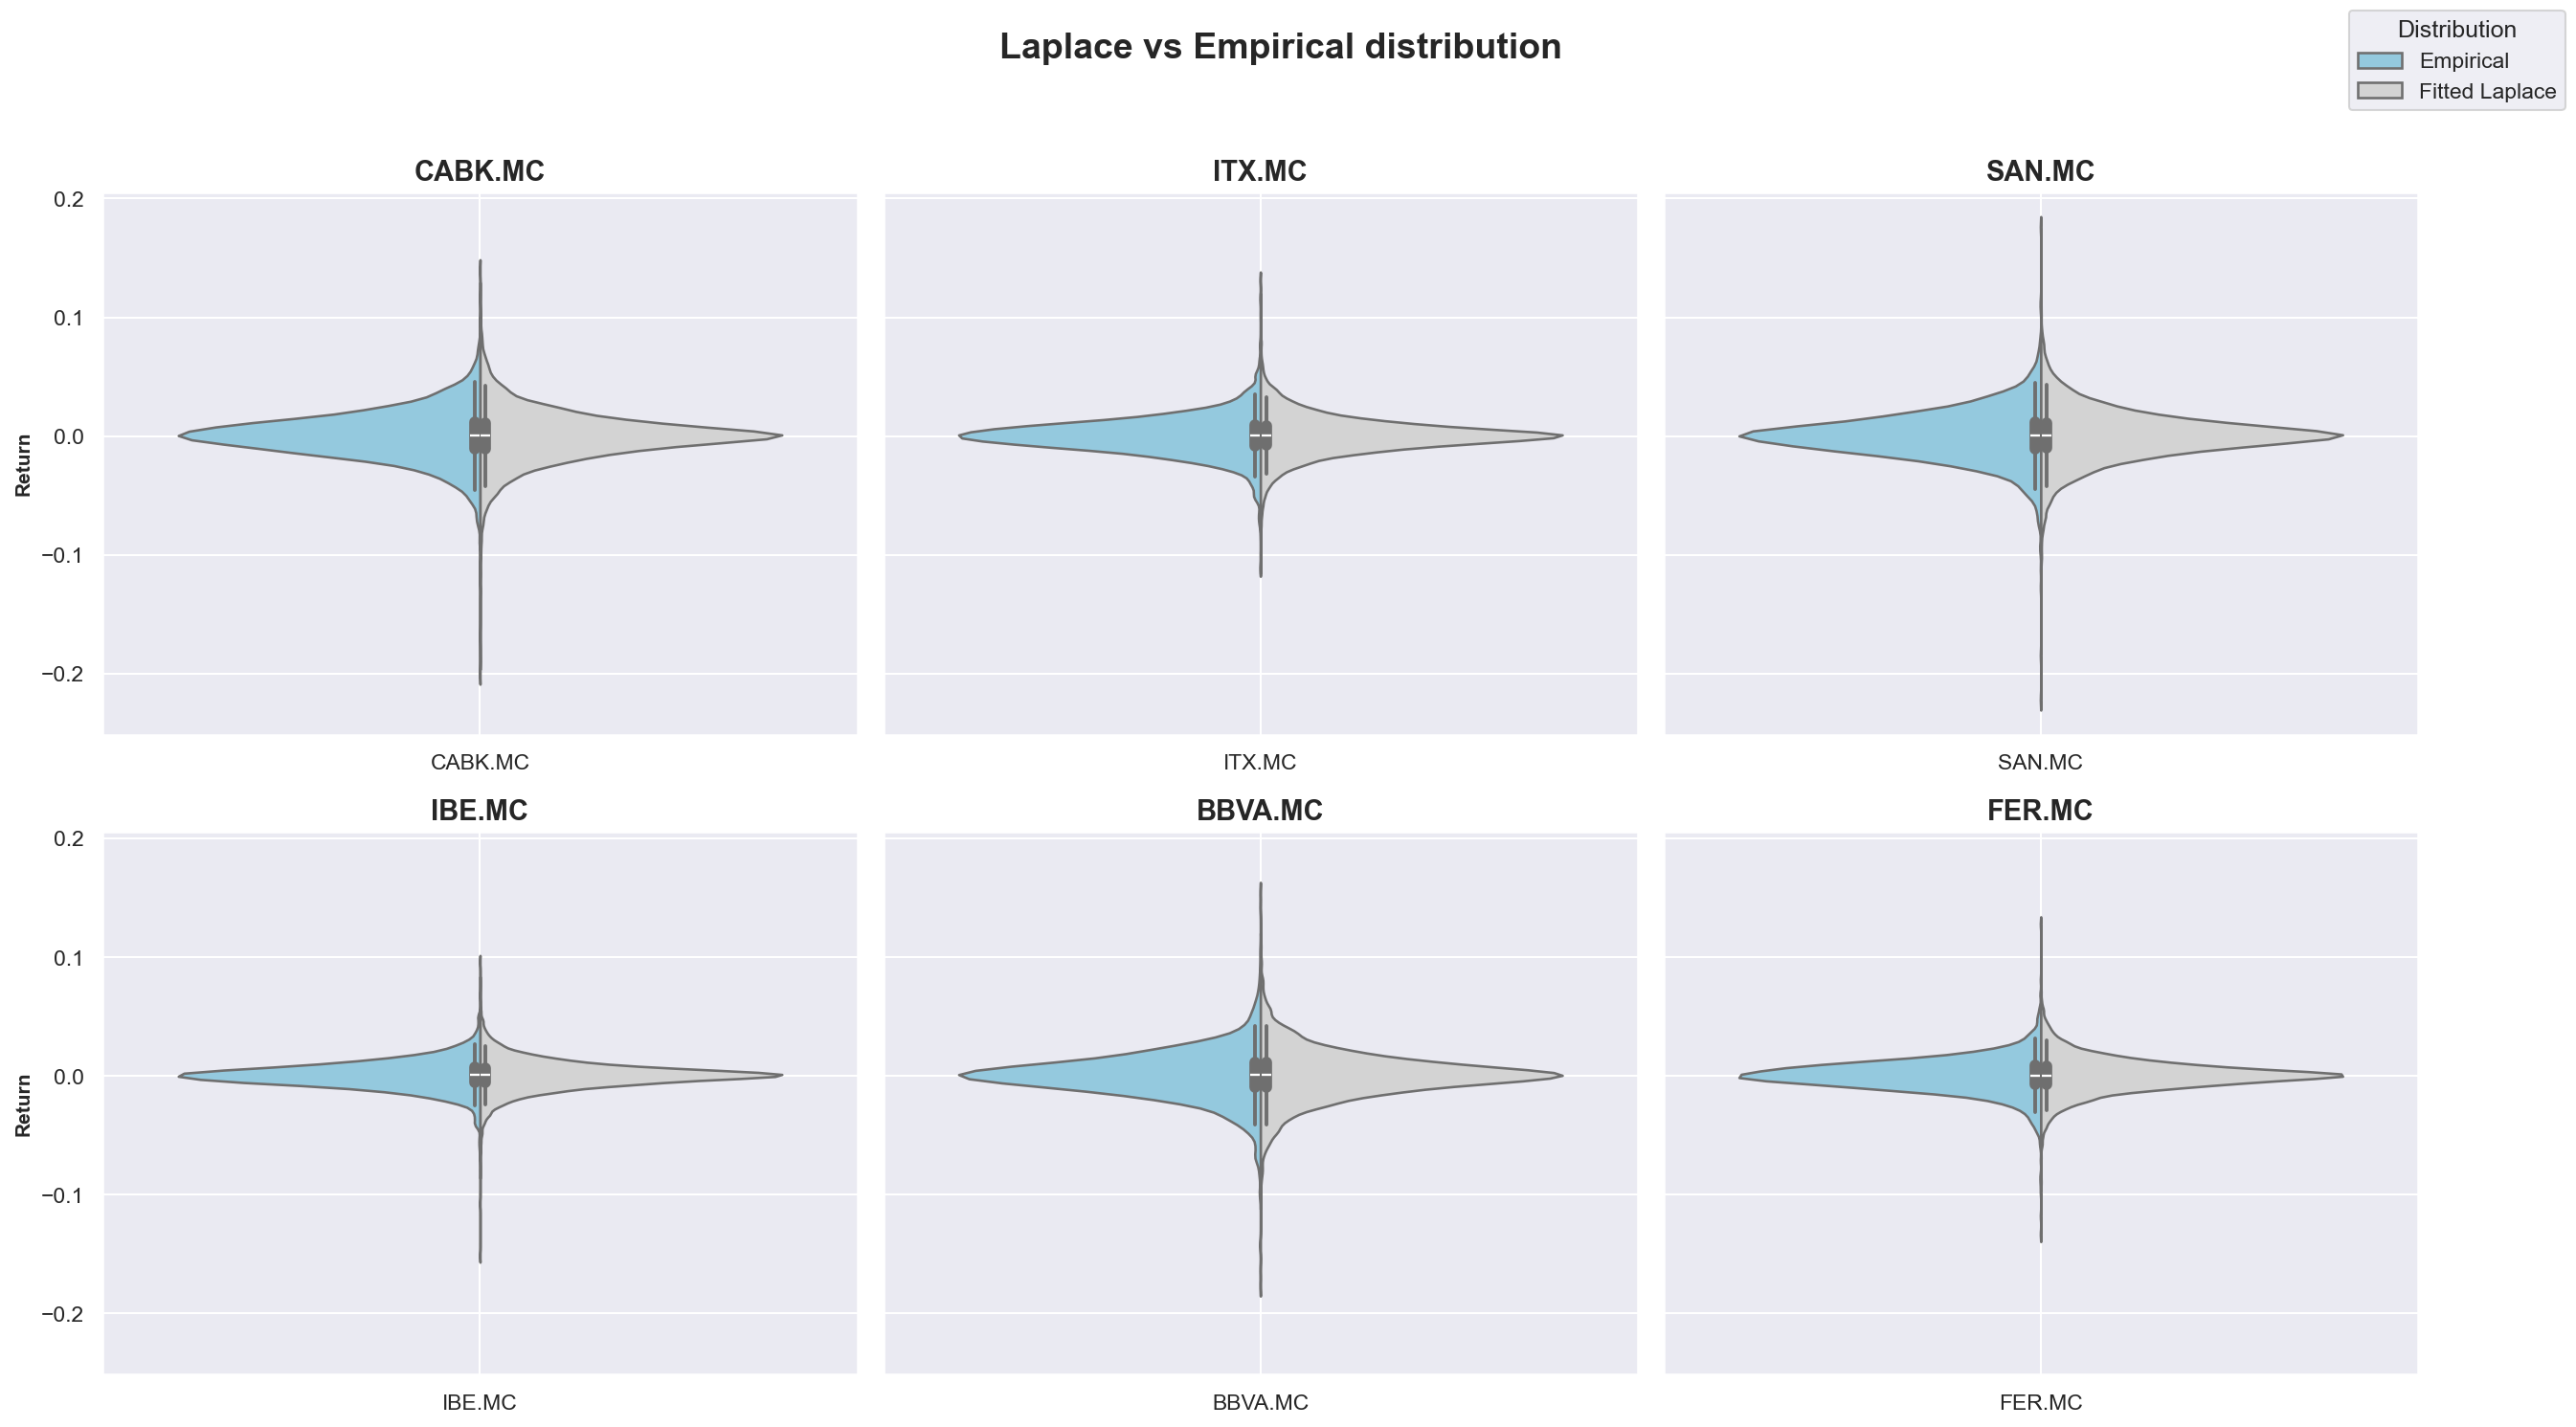

In [6]:
def plot_split_violins(data, assets, n_samples=10000):

    all_data = []
    for asset in assets:
        column = f"Close_{asset}"
        if column not in data.columns:
            raise ValueError(f"{column} not found in DataFrame.")

        empirical = data[column].dropna()
        mu, sigma = laplace.fit(empirical)
        synthetic = np.random.laplace(loc=mu, scale=sigma, size=n_samples)

        df_violin = pd.DataFrame({
            'Return': np.concatenate([empirical, synthetic]),
            'Source': ['Empirical'] * len(empirical) + ['Fitted Laplace'] * len(synthetic),
            'Asset': asset
        })
        all_data.append(df_violin)

    df_all = pd.concat(all_data, ignore_index=True)

    rows = 2
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(18, 10), dpi=150, sharey=True)
    axes = axes.flatten()

    for i, asset in enumerate(assets):
        sns.violinplot(
            data=df_all[df_all["Asset"] == asset],
            x="Asset", y="Return", hue="Source", split=True,
            palette={"Empirical": "skyblue", "Fitted Laplace": "lightgray"},
            ax=axes[i]
        )
        axes[i].set_title(asset, fontsize=14, fontweight='bold')
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Return" if i % cols == 0 else "", fontsize=10, fontweight='bold')
        axes[i].grid(True)
        axes[i].get_legend().remove()

    for j in range(len(assets), len(axes)):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Distribution", loc="upper right")
    fig.suptitle("Laplace vs Empirical distribution", fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()
    
plot_split_violins(returns, assets=["CABK.MC", "ITX.MC", "SAN.MC", "IBE.MC", "BBVA.MC", "FER.MC"])

### 2.2.1. Hypothesis test

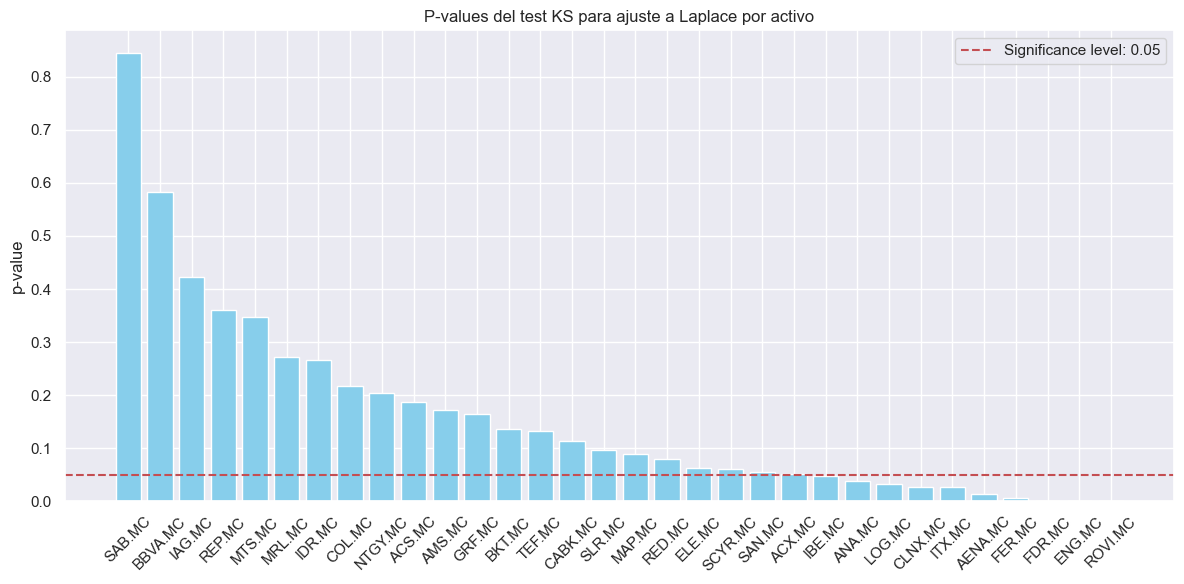

In [7]:
def bootstrap_laplace_errors(data, n_boot=500, random_state=None):
    rng = np.random.default_rng(random_state)
    locs = []
    scales = []
    n = len(data)

    for _ in range(n_boot):
        sample = rng.choice(data, size=n, replace=True)
        loc, scale = laplace.fit(sample)
        locs.append(loc)
        scales.append(scale)

    loc_std = np.std(locs, ddof=1)
    scale_std = np.std(scales, ddof=1)
    return loc_std, scale_std

results = []

for col in returns.columns:
    returns_data = returns[col].dropna()
    loc, scale = laplace.fit(returns_data)
    ks_stat, p_value = stats.kstest(returns_data, "laplace", args=(loc, scale))

    # Bootstrap standard errors
    se_loc, se_scale = bootstrap_laplace_errors(returns_data, n_boot=500)

    results.append({
        'Asset': col.replace("Close_", ""),
        'loc': loc,
        'scale': scale,
        'se_loc': se_loc,
        'se_scale': se_scale,
        'p_value': p_value,
        'ks_stat': ks_stat
    })

results = pd.DataFrame(results)
results = results.sort_values(by='p_value', ascending=False)

results.to_csv('../data/returns_fit.csv', index=False)

plt.figure(figsize=(12, 6))
plt.bar(results['Asset'], results['p_value'], color='skyblue')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance level: 0.05')
plt.xticks(rotation=45)
plt.ylabel('p-value')
plt.title('P-values del test KS para ajuste a Laplace por activo')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
def bootstrap_normal_errors(data, n_boot=500, random_state=None):
    rng = np.random.default_rng(random_state)
    locs = []
    scales = []
    n = len(data)

    for _ in range(n_boot):
        sample = rng.choice(data, size=n, replace=True)
        loc, scale = norm.fit(sample)
        locs.append(loc)
        scales.append(scale)

    loc_std = np.std(locs, ddof=1)
    scale_std = np.std(scales, ddof=1)
    return loc_std, scale_std

results_normal = []

for col in returns.columns:
    returns_data = returns[col].dropna()
    loc, scale = norm.fit(returns_data)
    ks_stat, p_value = stats.kstest(returns_data, "norm", args=(loc, scale))

    # Bootstrap standard errors
    se_loc, se_scale = bootstrap_laplace_errors(returns_data, n_boot=500)

    results_normal.append({
        'Asset': col.replace("Close_", ""),
        'loc': loc,
        'scale': scale,
        'se_loc': se_loc,
        'se_scale': se_scale,
        'p_value': p_value,
        'ks_stat': ks_stat
    })

results_normal = pd.DataFrame(results_normal)
results_normal = results_normal.sort_values(by='p_value', ascending=False)

results_normal.to_csv('../data/returns_fit_normal.csv', index=False)

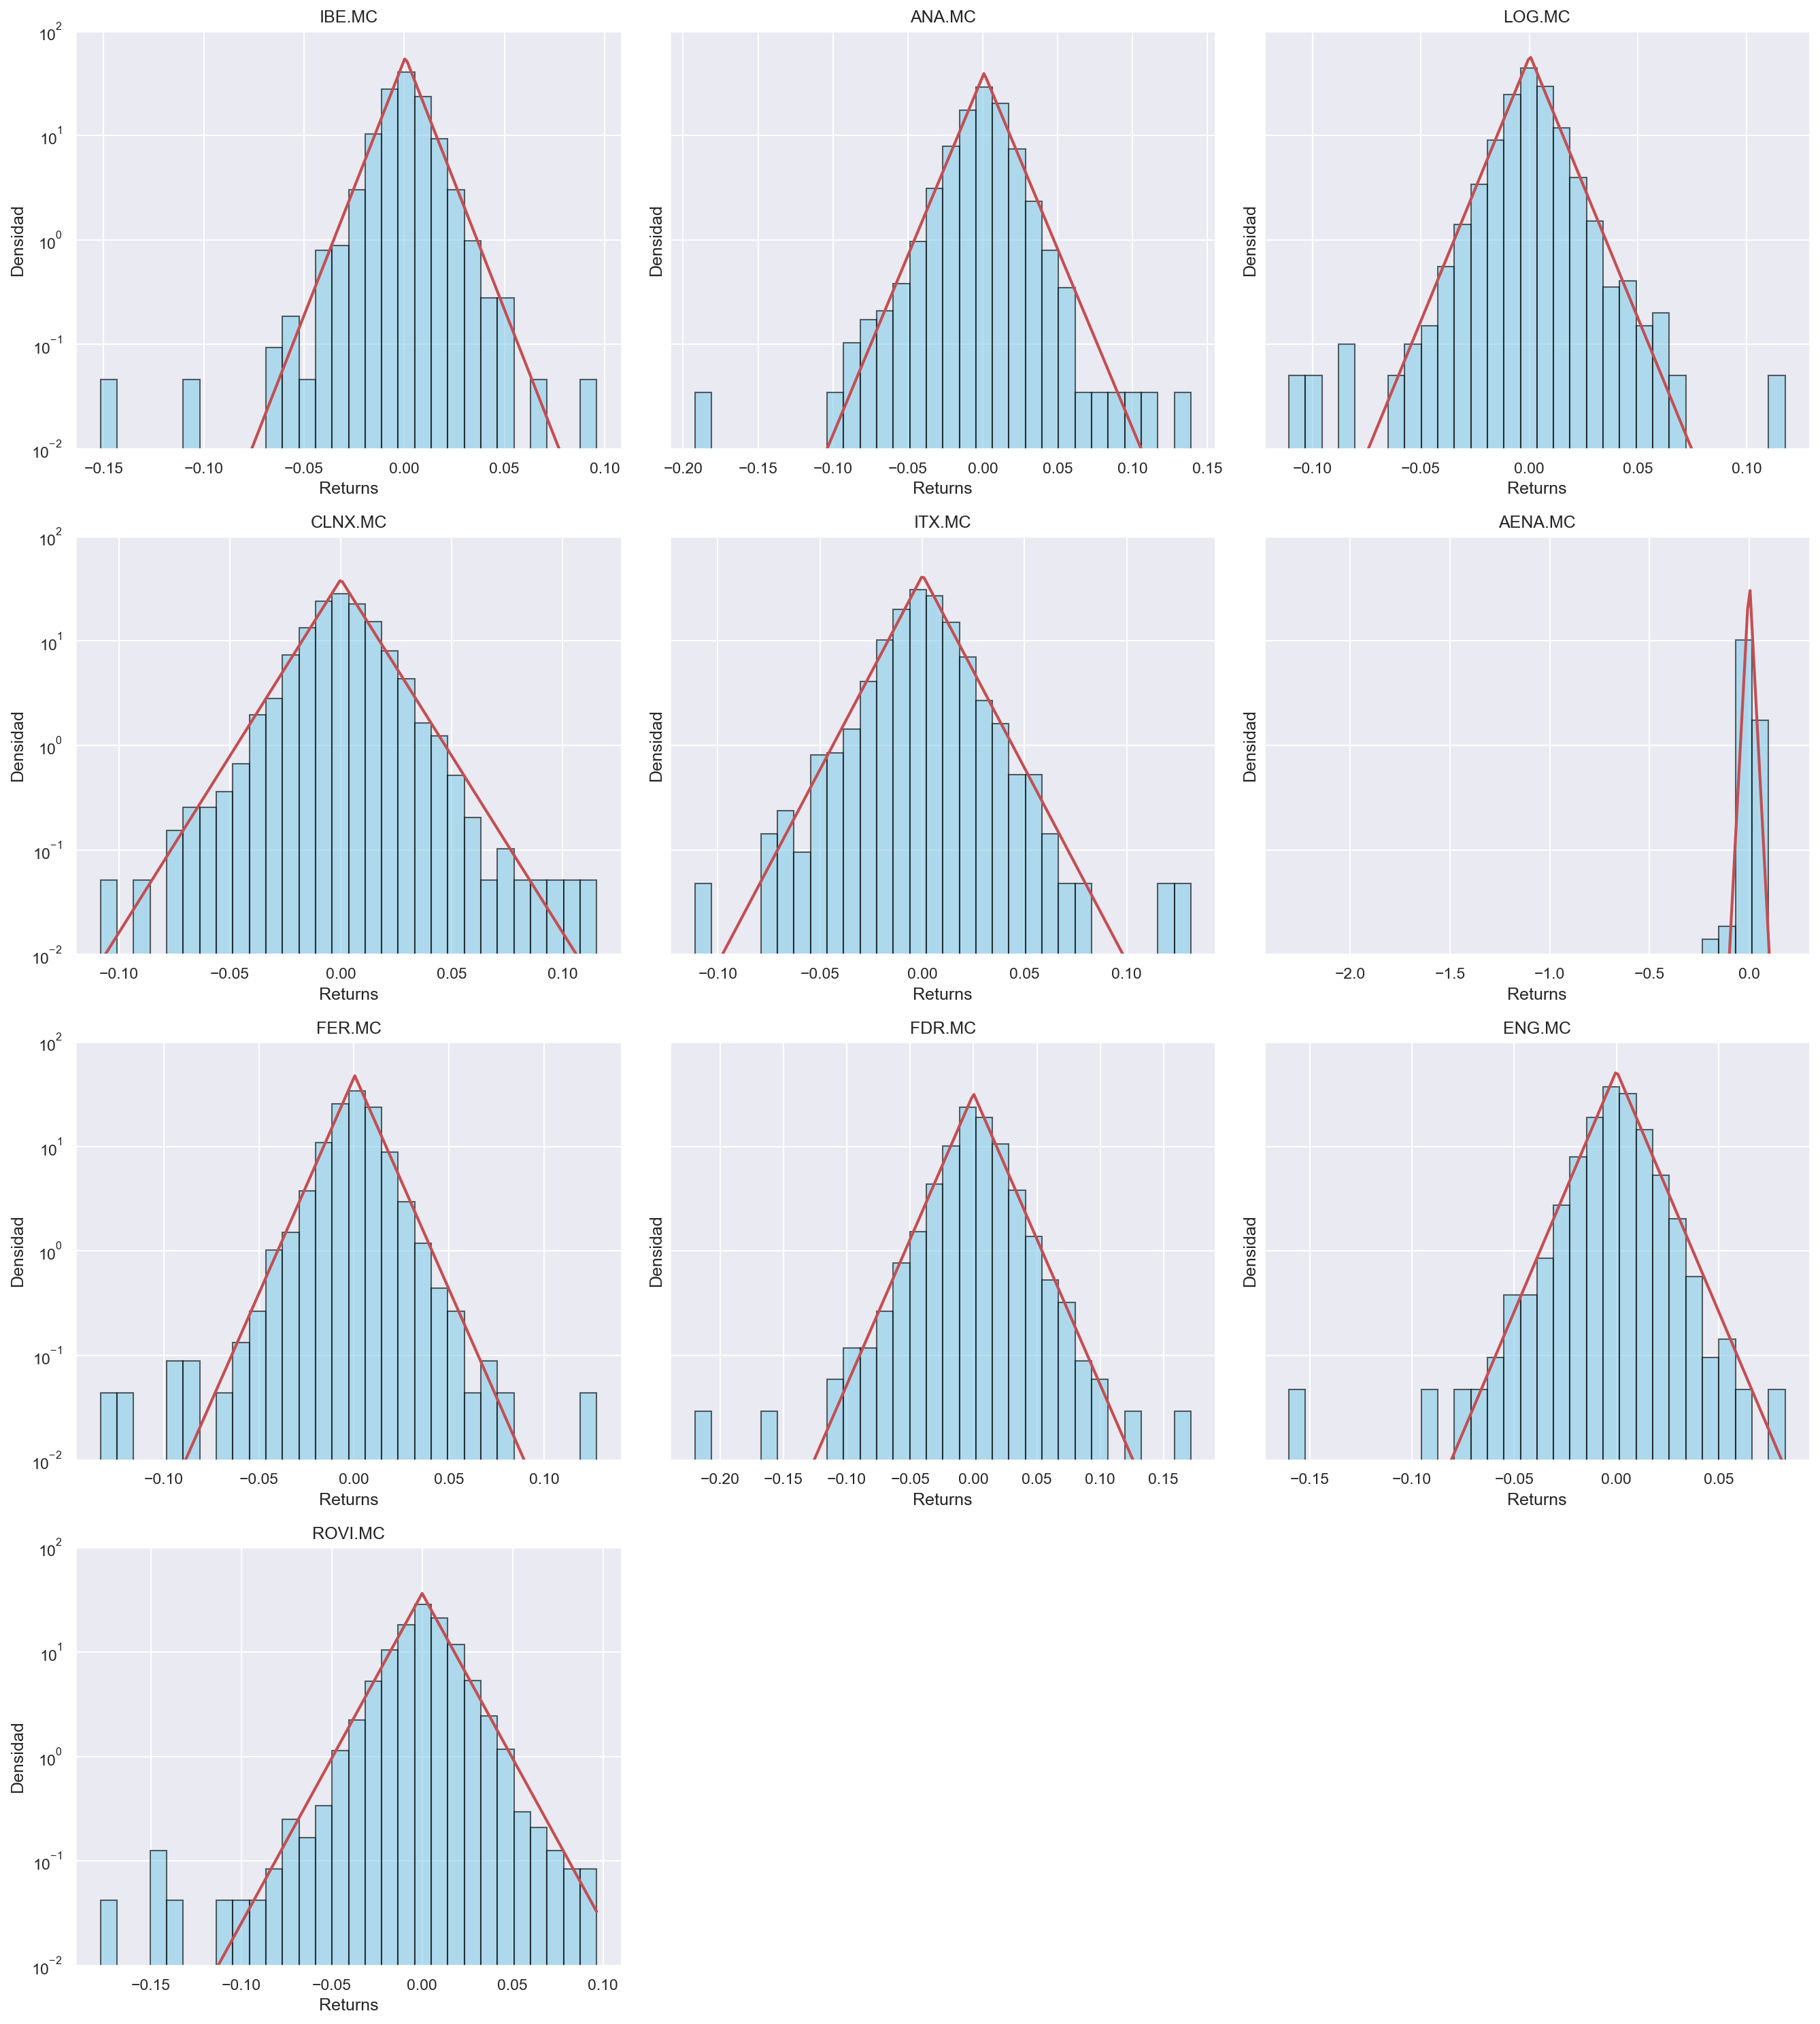

In [9]:
assets_rechazados = results[results['p_value'] < 0.05]['Asset']

assets = list(assets_rechazados)
cols = 3
rows = math.ceil(len(assets) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows), dpi=150, sharey=True)
axes = axes.flatten()

for i, asset in enumerate(assets):
    ax = axes[i]
    asset_return = returns[f"Close_{asset}"].dropna()

    ax.hist(asset_return, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.6)

    fit_params = results[results['Asset'] == asset].iloc[0]
    loc = fit_params['loc']
    scale = fit_params['scale']

   
    x = np.linspace(asset_return.min(), asset_return.max(), 200)
    y = laplace.pdf(x, loc, scale)
    ax.plot(x, y, 'r-', lw=2)
    ax.set_yscale("log")
    ax.set_ylim(1e-2, 1e2)
    ax.set_title(f"{asset}")
    ax.set_xlabel('Returns')
    ax.set_ylabel('Densidad')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 2.3 Volatiliy

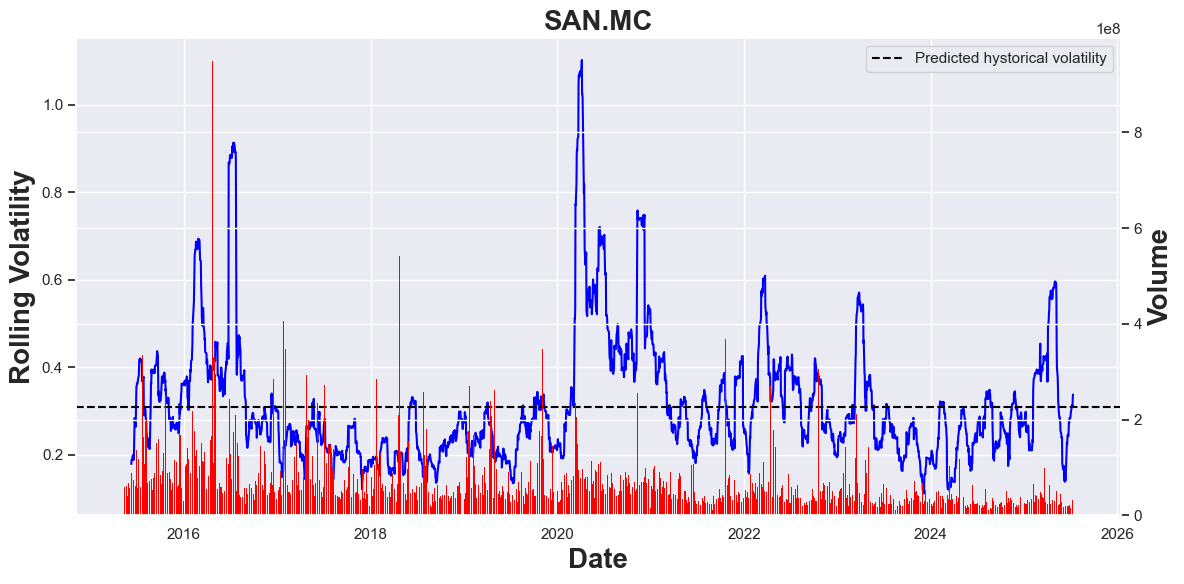

In [10]:
def Rolling_Vol(data, data2, results, asset_name):
    sns.set(style="darkgrid")
    rolling_vol = data[f"Close_{asset_name}"].rolling(window=21).std() * np.sqrt(252)
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    fit_params = results[results['Asset'] == asset].iloc[0]
    loc = fit_params['loc']
    scale = fit_params['scale']
    
    pred_vol = np.sqrt(2)*scale* np.sqrt(252)
    
    # Rolling Volatility
    sns.lineplot(data=data, x=data.index,y=rolling_vol, ax=ax1, color='blue')
    ax1.set_xlabel("Date", fontsize=20, fontweight='bold')
    ax1.set_ylabel("Rolling Volatility", fontsize=20, fontweight='bold')
    
    ax1.axhline(y=pred_vol, color='black', linestyle='--', label='Predicted hystorical volatility')
    ax1.legend()
    ax1.tick_params(axis='y')

    # Volume
    volume_col = f"Volume_{asset_name}"
    
    if volume_col in data2.columns:
        ax2 = ax1.twinx()
        ax2.bar( data2.index, data2[volume_col], color='red', edgecolor='black', linewidth=0, width=1   )

        ax2.set_ylabel("Volume", fontsize=20, fontweight='bold')
        ax2.tick_params(axis='y')


    plt.title(asset_name, fontsize=20, fontweight='bold')
    plt.tight_layout()

    plt.show()
    
Rolling_Vol(returns, data, results, "SAN.MC")

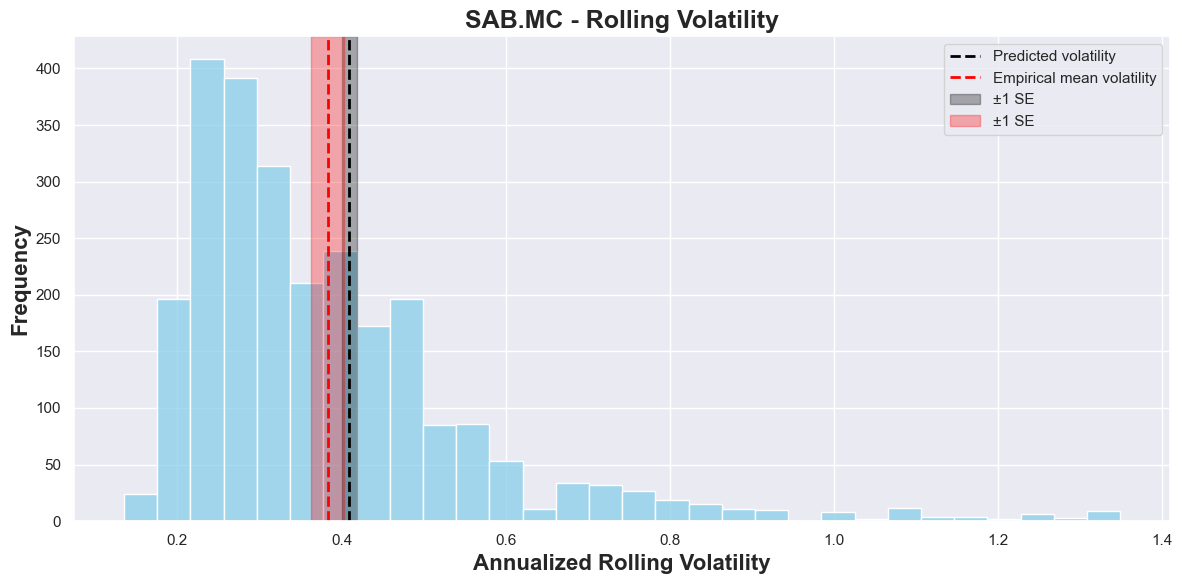

In [11]:
def estimate_se_binning(vol_series, bin_size):
    n = len(vol_series)
    n_bins = n // bin_size
    # Truncate to full bins
    trimmed = vol_series[:n_bins * bin_size]
    bins = trimmed.values.reshape(n_bins, bin_size)
    bin_means = bins.mean(axis=1)
    se = bin_means.std(ddof=1) / np.sqrt(n_bins)
    return se, n_bins


def Rolling_Vol_hist(data, results, asset_name, window=21):
    sns.set(style="darkgrid")

    rolling_vol = data[f"Close_{asset_name}"].rolling(window=window).std().dropna() * np.sqrt(252)
    n = len(rolling_vol)

    mean_vol = rolling_vol.mean()

    se, n_eff = estimate_se_binning(rolling_vol, bin_size=window*2)

    fit_params = results[results['Asset'] == asset_name].iloc[0]
    loc = fit_params['loc']
    scale = fit_params['scale']
    pred_vol = np.sqrt(2) * scale * np.sqrt(252)
    se_t = np.sqrt(2*252) * fit_params['se_scale']
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    sns.histplot(rolling_vol, kde=False, ax=ax1, color='skyblue', bins=30)

    ax1.axvline(x=pred_vol, color='black', linestyle='--', linewidth=2, label='Predicted volatility')
    ax1.axvline(x=mean_vol, color='red', linestyle='--', linewidth=2, label='Empirical mean volatility')
    
    ax1.axvspan(pred_vol - se_t, pred_vol + se_t, color='black', alpha=0.3, label='±1 SE')
    ax1.axvspan(mean_vol - se, mean_vol + se, color='red', alpha=0.3, label='±1 SE')

    ax1.set_xlabel("Annualized Rolling Volatility", fontsize=16, fontweight='bold')
    ax1.set_ylabel("Frequency", fontsize=16, fontweight='bold')
    ax1.set_title(asset_name + " - Rolling Volatility", fontsize=18, fontweight='bold')
    ax1.legend()
    plt.tight_layout()
    plt.show()


Rolling_Vol_hist(returns, results, "SAB.MC", window=21)

# Summary
- Log-returns obtained for 32 IBEX 35 assets over 10+ years.
- Fitted log-returns to normal and Laplace distributions.
- Laplace distributions perform better to model the daily returns although it still can not capture correctly extreme events
- Hystorical volatility is higher than in the standard model
- However, real volatility evolve in time showing volatility clustering, which is not captured with this model.

The next step is to compute correlations between different assets returns, which will be handled in the Correlations.ipynb notebook.